STEP 0: Loading data - Alpha
Reading file: /home/agata/Desktop/mother_infant_neural_synchrony/results/validated_data_alpha_wpli.csv
First 5 rows:
   participant       fp1       sf1       fp2       sf2   reunion
0           29  0.368021  0.355404  0.358243  0.356799  0.370489
1           35  0.347988  0.360220  0.355865  0.354701  0.379312
2           36  0.350884  0.344430  0.346340  0.356794  0.375399
3           49  0.378365  0.341424  0.393290  0.345490  0.381010
4           50  0.347258  0.348664  0.341352  0.335887  0.349518

Data shape: 33 participants x 6 columns

STEP 1: Normality check (Shapiro-Wilk per condition)
Condition: fp1
  Shapiro-Wilk W = 0.9046, p = 0.0070
  -> p < 0.05: significant deviation from normality (NOT normal)

Condition: sf1
  Shapiro-Wilk W = 0.8333, p = 0.0001
  -> p < 0.05: significant deviation from normality (NOT normal)

Condition: fp2
  Shapiro-Wilk W = 0.9199, p = 0.0182
  -> p < 0.05: significant deviation from normality (NOT normal)

Condition: s

/tmp/ipykernel_11907/4160197603.py:274: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


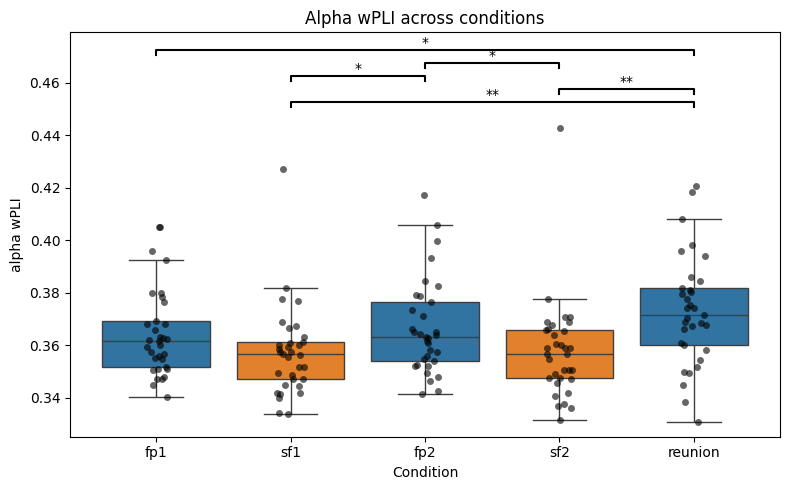

STEP 0: Loading data - Theta
Reading file: /home/agata/Desktop/mother_infant_neural_synchrony/results/validated_data_theta_wpli.csv
First 5 rows:
   participant       fp1       sf1       fp2       sf2   reunion
0           29  0.430333  0.394683  0.405666  0.474606  0.437633
1           35  0.401038  0.365051  0.398884  0.406845  0.411660
2           36  0.375902  0.376933  0.389935  0.420379  0.381480
3           49  0.437913  0.368327  0.395889  0.378986  0.418898
4           50  0.382372  0.392160  0.396627  0.396542  0.397445

Data shape: 33 participants x 6 columns

STEP 1: Normality check (Shapiro-Wilk per condition)
Condition: fp1
  Shapiro-Wilk W = 0.9449, p = 0.0944
  -> p ≥ 0.05: no significant deviation from normality (OK)

Condition: sf1
  Shapiro-Wilk W = 0.9531, p = 0.1637
  -> p ≥ 0.05: no significant deviation from normality (OK)

Condition: fp2
  Shapiro-Wilk W = 0.8932, p = 0.0036
  -> p < 0.05: significant deviation from normality (NOT normal)

Condition: sf2
  Shapi

/tmp/ipykernel_11907/4160197603.py:274: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


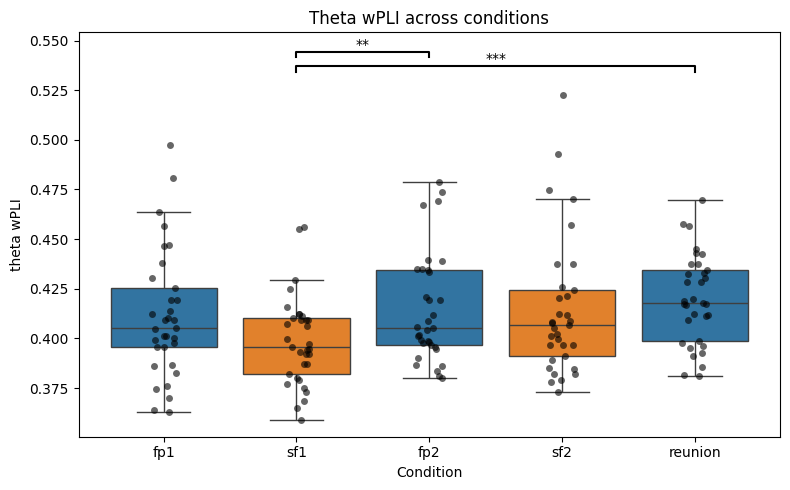

In [3]:
import os
import itertools
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Global settings
COLS = ['fp1', 'sf1', 'fp2', 'sf2', 'reunion']
ALPHA_LEVEL = 0.05

# for plotting
PALETTE = {
    'fp1': '#1f77b4', # blue-ish
    'fp2': '#1f77b4',
    'reunion': '#1f77b4',
    'sf1': '#ff7f0e', # orange-ish
    'sf2': '#ff7f0e',
}

# Holm-Bonferroni helper
def holm_adjust(pvals):
    """Holm step-down adjustment; returns adjusted p in original order."""
    pvals = np.array(pvals, dtype=float)
    m = len(pvals)
    order = np.argsort(pvals)
    adj = np.empty(m)
    prev = 0
    for k, i in enumerate(order):
        factor = m - k
        val = min(1.0, pvals[i] * factor)
        if k == 0:
            adj[i] = val
        else:
            adj[i] = max(prev, val)
        prev = adj[i]
    return adj

# FDR (Benjamini–Hochberg) helper
def fdr_bh(pvals):
    """
    Benjamini–Hochberg FDR adjustment.
    Returns q-values (FDR-adjusted p) in the original order.
    """
    pvals = np.array(pvals, dtype=float)
    m = len(pvals)
    order = np.argsort(pvals)
    ranked_p = pvals[order]

    q_ranked = np.empty(m)
    prev = 1.0
    # go from largest to smallest to enforce monotonicity
    for i in range(m - 1, -1, -1):
        rank = i + 1
        val = ranked_p[i] * m / rank
        if val > 1.0:
            val = 1.0
        if val < prev:
            prev = val
        q_ranked[i] = prev

    qvals = np.empty(m)
    qvals[order] = q_ranked
    return qvals

# Main analysis function
def run_band_analysis(csv_path, band_name, cols=COLS, alpha_level=ALPHA_LEVEL):
    """
    Load csv, run Shapiro, Friedman, Wilcoxon + Holm + FDR (BH).
    Prints step-by-step output and returns:
      df, wilcoxon_df_sorted, sig_pairs_list

    sig_pairs_list is based on FDR-adjusted p-values:
      [(cond1, cond2, p_fdr), ...] for p_fdr < alpha.
    """
    print("="*80)
    print(f"STEP 0: Loading data - {band_name}")
    print("="*80)
    print(f"Reading file: {csv_path}")

    df = pd.read_csv(csv_path)
    print("First 5 rows:")
    print(df.head())
    print(f"\nData shape: {df.shape[0]} participants x {df.shape[1]} columns\n")

    # ----------------- STEP 1: Normality -----------------
    print("="*80)
    print("STEP 1: Normality check (Shapiro-Wilk per condition)")
    print("="*80)

    normality_results = []
    for c in cols:
        stat, p = stats.shapiro(df[c])
        is_normal = p >= alpha_level
        normality_results.append((c, stat, p, is_normal))

        print(f"Condition: {c}")
        print(f"  Shapiro-Wilk W = {stat:.4f}, p = {p:.4f}")
        if is_normal:
            print(f"  -> p ≥ {alpha_level:.2f}: no significant deviation from normality (OK)")
        else:
            print(f"  -> p < {alpha_level:.2f}: significant deviation from normality (NOT normal)")
        print()

    normality_df = pd.DataFrame(
        normality_results,
        columns=["condition", "W", "p_value", "normal_(p>=0.05)"]
    )
    print("Summary of normality tests:")
    print(normality_df.to_string(index=False))
    print()

    # ----------------- STEP 2: Friedman ------------------
    print("="*80)
    print("STEP 2: Friedman test (overall differences between conditions)")
    print("="*80)

    friedman_stat, friedman_p = stats.friedmanchisquare(
        *[df[c] for c in cols]
    )

    print(f"Friedman χ²(df = {len(cols)-1}) = {friedman_stat:.4f}, p = {friedman_p:.6f}")
    if friedman_p < alpha_level:
        print(f"-> p < {alpha_level:.2f}: significant overall effect of condition.")
        print("   Proceeding to post-hoc pairwise comparisons (Wilcoxon).\n")
    else:
        print(f"-> p ≥ {alpha_level:.2f}: no significant overall effect of condition.")
        print("   Post-hoc tests can be viewed as exploratory.\n")

    # -------- STEP 3: Pairwise Wilcoxon + direction ------
    print("="*80)
    print("STEP 3: Pairwise Wilcoxon signed-rank tests + direction of differences")
    print("="*80)

    pairs = list(itertools.combinations(cols, 2))
    wilcoxon_results = []

    for a, b in pairs:
        stat, p = stats.wilcoxon(
            df[a], df[b],
            alternative='two-sided',
            zero_method='wilcox'
        )

        diff = df[b] - df[a]       # B - A
        mean_diff = diff.mean()
        median_diff = diff.median()

        if median_diff > 0:
            direction = f"{b} > {a}"
        elif median_diff < 0:
            direction = f"{b} < {a}"
        else:
            direction = "no median difference"

        wilcoxon_results.append(
            (a, b, stat, p, mean_diff, median_diff, direction)
        )

        print(f"Pair: {a} vs {b}")
        print(f"  Wilcoxon W = {stat:.4f}, raw p = {p:.6f}")
        print(f"  Mean({b} - {a})   = {mean_diff:.6f}")
        print(f"  Median({b} - {a}) = {median_diff:.6f}")
        print(f"  Direction: {direction} "
              f"({'b more positive / less negative than a' if median_diff > 0 else 'b more negative / lower than a' if median_diff < 0 else 'no clear difference'})")
        print()

    wilcoxon_df = pd.DataFrame(
        wilcoxon_results,
        columns=["cond1", "cond2", "W", "p_raw",
                 "mean_diff_B_minus_A", "median_diff_B_minus_A", "direction"]
    )

    # ----------------- STEP 4: Holm + FDR ----------------
    print("="*80)
    print("STEP 4: Holm-Bonferroni and FDR (Benjamini–Hochberg) corrections")
    print("="*80)

    pvals = wilcoxon_df["p_raw"].values
    wilcoxon_df["p_holm"] = holm_adjust(pvals)
    wilcoxon_df["p_fdr"] = fdr_bh(pvals)

    # For display & interpretation we sort by FDR (you can change to p_holm if you prefer)
    wilcoxon_df_sorted = wilcoxon_df.sort_values("p_fdr").reset_index(drop=True)

    print("Pairwise comparisons with direction and adjusted p-values:")
    print(wilcoxon_df_sorted.to_string(index=False))
    print()

    # ---------------- STEP 5: Interpretation -------------
    print("="*80)
    print(f"STEP 5: Interpretation (α = {alpha_level}) - using FDR (BH) as criterion")
    print("="*80)

    # use FDR for significance; still print Holm for reference
    sig_df = wilcoxon_df_sorted[wilcoxon_df_sorted["p_fdr"] < alpha_level]
    if sig_df.empty:
        print("No pairwise differences remain significant after FDR correction.")
    else:
        print("Significant pairwise differences after FDR (BH) correction:")
        for _, row in sig_df.iterrows():
            a = row["cond1"]
            b = row["cond2"]
            W = row["W"]
            p_raw = row["p_raw"]
            p_holm = row["p_holm"]
            p_fdr = row["p_fdr"]
            median_diff = row["median_diff_B_minus_A"]
            direction = row["direction"]
            print(f"- {a} vs {b}: W = {W:.4f}, raw p = {p_raw:.6f}, "
                  f"Holm p = {p_holm:.6f}, FDR p = {p_fdr:.6f}")
            print(f"  Direction (based on median({b} - {a})): {direction}, "
                  f"median difference = {median_diff:.6f}")
        print()

    print("Non-significant pairs (FDR-adjusted p ≥ 0.05):")
    nonsig_df = wilcoxon_df_sorted[wilcoxon_df_sorted["p_fdr"] >= alpha_level]
    if nonsig_df.empty:
        print("  None.")
    else:
        for _, row in nonsig_df.iterrows():
            a = row["cond1"]
            b = row["cond2"]
            p_fdr = row["p_fdr"]
            direction = row["direction"]
            print(f"- {a} vs {b}: FDR p = {p_fdr:.6f}, direction (median-based) = {direction}")

    # list of significant pairs for plotting (based on FDR)
    sig_pairs = [
        (row["cond1"], row["cond2"], row["p_fdr"])
        for _, row in sig_df.iterrows()
    ]

    return df, wilcoxon_df_sorted, sig_pairs


# Plotting helpers
def p_to_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'

def add_sig_bar(ax, cond1, cond2, p, cols_order,
                y_start, height, line_width=1.5):
    x1 = cols_order.index(cond1)
    x2 = cols_order.index(cond2)
    y = y_start
    h = height
    ax.plot([x1, x1, x2, x2],
            [y, y + h, y + h, y],
            color='black',
            linewidth=line_width)
    stars = p_to_stars(p)
    ax.text((x1 + x2) / 2, y + h,
            stars, ha='center', va='bottom')

def plot_box_with_sig(df, band_name, value_label, sig_pairs,
                      cols=COLS, palette=PALETTE):
    df_long = df.reset_index(names='subject').melt(
        id_vars='subject',
        value_vars=cols,
        var_name='condition',
        value_name='value'
    )

    fig, ax = plt.subplots(figsize=(8, 5))

    sns.boxplot(
        data=df_long,
        x='condition',
        y='value',
        order=cols,
        palette=palette,
        showfliers=False,
        ax=ax
    )

    sns.stripplot(
        data=df_long,
        x='condition',
        y='value',
        order=cols,
        color='black',
        alpha=0.6,
        jitter=0.1,
        ax=ax
    )

    ax.set_xlabel("Condition")
    ax.set_ylabel(value_label)
    ax.set_title(f"{band_name} wPLI across conditions")

    # place sig bars (for FDR-significant pairs)
    y_min, y_max = ax.get_ylim()
    y_range = y_max - y_min
    base = y_max + 0.02 * y_range
    step = 0.04 * y_range
    bar_height = 0.015 * y_range

    for i, (c1, c2, p) in enumerate(sig_pairs):
        add_sig_bar(
            ax,
            cond1=c1,
            cond2=c2,
            p=p,
            cols_order=cols,
            y_start=base + i * step,
            height=bar_height
        )

    ax.set_ylim(y_min, base + len(sig_pairs) * step + 2 * bar_height)
    plt.tight_layout()
    plt.show()


# Load the data
alpha_path = os.path.join(os.getcwd(), "results", "validated_data_alpha_wpli.csv")
theta_path = os.path.join(os.getcwd(), "results", "validated_data_theta_wpli.csv")

# Alpha
df_alpha, res_alpha, sig_alpha = run_band_analysis(alpha_path, band_name="Alpha")
plot_box_with_sig(df_alpha, band_name="Alpha", value_label="alpha wPLI",
                  sig_pairs=sig_alpha)

# Theta
df_theta, res_theta, sig_theta = run_band_analysis(theta_path, band_name="Theta")
plot_box_with_sig(df_theta, band_name="Theta", value_label="theta wPLI",
                  sig_pairs=sig_theta)


Alpha z-outliers: {576, 684}
STEP 0: Loading data - Alpha (no outliers)
Reading file: /home/agata/Desktop/mother_infant_neural_synchrony/results/alpha_wpli_no.csv
First 5 rows:
   Unnamed: 0  participant       fp1       sf1       fp2       sf2   reunion
0           0           29  0.368021  0.355404  0.358243  0.356799  0.370489
1           1           35  0.347988  0.360220  0.355865  0.354701  0.379312
2           2           36  0.350884  0.344430  0.346340  0.356794  0.375399
3           3           49  0.378365  0.341424  0.393290  0.345490  0.381010
4           4           50  0.347258  0.348664  0.341352  0.335887  0.349518

Data shape: 31 participants x 7 columns

STEP 1: Normality check (Shapiro-Wilk per condition)
Condition: fp1
  Shapiro-Wilk W = 0.9086, p = 0.0119
  -> p < 0.05: significant deviation from normality (NOT normal)

Condition: sf1
  Shapiro-Wilk W = 0.9690, p = 0.4926
  -> p ≥ 0.05: no significant deviation from normality (OK)

Condition: fp2
  Shapiro-Wilk W =

/tmp/ipykernel_11907/4160197603.py:274: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


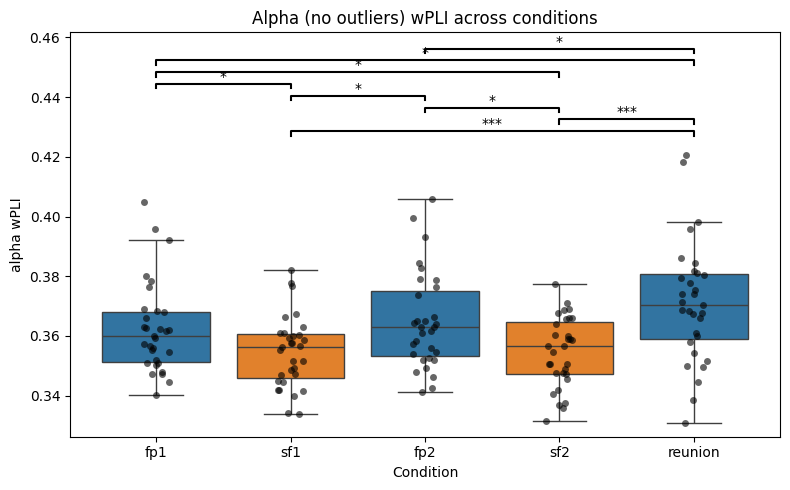

Theta z-outliers: {212}
STEP 0: Loading data - Theta (no outliers)
Reading file: /home/agata/Desktop/mother_infant_neural_synchrony/results/theta_wpli_no.csv
First 5 rows:
   Unnamed: 0  participant       fp1       sf1       fp2       sf2   reunion
0           0           29  0.430333  0.394683  0.405666  0.474606  0.437633
1           1           35  0.401038  0.365051  0.398884  0.406845  0.411660
2           2           36  0.375902  0.376933  0.389935  0.420379  0.381480
3           3           49  0.437913  0.368327  0.395889  0.378986  0.418898
4           4           50  0.382372  0.392160  0.396627  0.396542  0.397445

Data shape: 32 participants x 7 columns

STEP 1: Normality check (Shapiro-Wilk per condition)
Condition: fp1
  Shapiro-Wilk W = 0.9487, p = 0.1322
  -> p ≥ 0.05: no significant deviation from normality (OK)

Condition: sf1
  Shapiro-Wilk W = 0.9524, p = 0.1691
  -> p ≥ 0.05: no significant deviation from normality (OK)

Condition: fp2
  Shapiro-Wilk W = 0.8920, p

/tmp/ipykernel_11907/4160197603.py:274: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


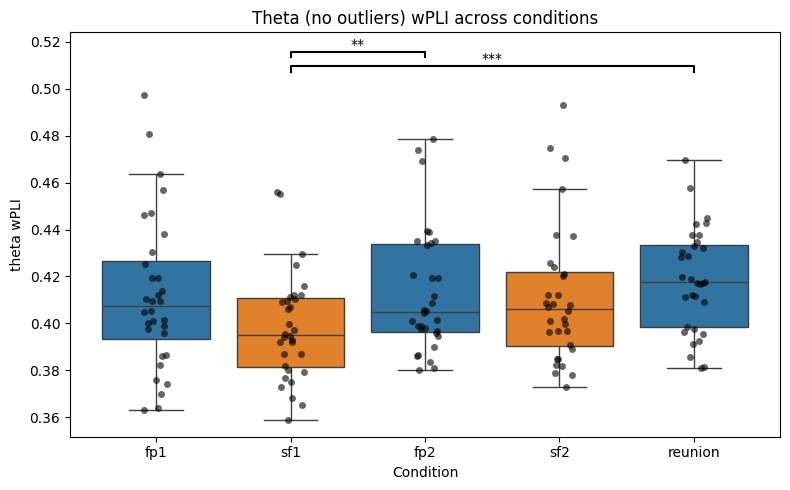

In [6]:
def subjects_with_z_outliers(df, cols, z_thresh=3.0):
    ids = set()
    for c in cols:
        x = df[c]
        z = (x - x.mean()) / x.std(ddof=1)
        ids |= set(df.loc[z.abs() > z_thresh, 'participant'])
    return ids

# --- Alpha without outliers ---
alpha_path = os.path.join(os.getcwd(), "results", "validated_data_alpha_wpli.csv")
df_alpha = pd.read_csv(alpha_path)

alpha_out_ids = subjects_with_z_outliers(df_alpha, COLS, z_thresh=3.0)
print("Alpha z-outliers:", alpha_out_ids)

df_alpha_no = df_alpha[~df_alpha['participant'].isin(alpha_out_ids)]
df_alpha_no = df_alpha_no.reset_index(drop=True)

df_alpha_no.to_csv("results/alpha_wpli_no.csv")

_, res_alpha_no, sig_alpha_no = run_band_analysis(
    csv_path=os.path.join(os.getcwd(), "results", "alpha_wpli_no.csv"),   
    band_name="Alpha (no outliers)"
)
plot_box_with_sig(df_alpha_no, band_name="Alpha (no outliers)", value_label="alpha wPLI",
                  sig_pairs=sig_alpha_no)

# --- Theta without outliers ---
theta_path = os.path.join(os.getcwd(), "results", "validated_data_theta_wpli.csv")
df_theta = pd.read_csv(theta_path)

theta_out_ids = subjects_with_z_outliers(df_theta, COLS, z_thresh=3.0)
print("Theta z-outliers:", theta_out_ids)

df_theta_no = df_theta[~df_theta['participant'].isin(theta_out_ids)]
df_theta_no = df_theta_no.reset_index(drop=True)

df_theta_no.to_csv("results/theta_wpli_no.csv")

_, res_theta_no, sig_theta_no = run_band_analysis(
    csv_path=os.path.join(os.getcwd(), "results", "theta_wpli_no.csv"),         
    band_name="Theta (no outliers)"
)
plot_box_with_sig(df_theta_no, band_name="Theta (no outliers)", value_label="theta wPLI",
                  sig_pairs=sig_theta_no)

